In [1]:
import pandas as pd

# Đọc dữ liệu từ file CSV
df = pd.read_csv('../../merged_cleaned_dataset.csv')

# Đảm bảo không có NaN
df = df.dropna(subset=['title', 'content', 'label'])

# Tách thành danh sách
title_list = df['title'].astype(str).tolist()
content_list = df['content'].astype(str).tolist()
labels = df['label'].astype(int).tolist()  # hoặc float nếu cần


In [2]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

# Giới hạn số lượng từ
vocab_size = 10000
max_len_title = 30
max_len_content = 500

tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(title_list + content_list)

# Chuyển thành chuỗi số
X_title = tokenizer.texts_to_sequences(title_list)
X_content = tokenizer.texts_to_sequences(content_list)

X_title = pad_sequences(X_title, maxlen=max_len_title)
X_content = pad_sequences(X_content, maxlen=max_len_content)

y = np.array(labels)

# Tách train/val
X_title_train, X_title_val, X_content_train, X_content_val, y_train, y_val = train_test_split(
    X_title, X_content, y, test_size=0.2, random_state=42)


In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense, Dropout, Concatenate

embedding_dim = 100

# Nhánh xử lý title
input_title = Input(shape=(max_len_title,))
x1 = Embedding(vocab_size, embedding_dim)(input_title)
x1 = Bidirectional(LSTM(64))(x1)

# Nhánh xử lý content
input_content = Input(shape=(max_len_content,))
x2 = Embedding(vocab_size, embedding_dim)(input_content)
x2 = Bidirectional(LSTM(128))(x2)

# Kết hợp hai nhánh
combined = Concatenate()([x1, x2])
dense = Dense(64, activation='relu')(combined)
drop = Dropout(0.5)(dense)
output = Dense(1, activation='sigmoid')(drop)

# Khởi tạo và compile model
model = Model(inputs=[input_title, input_content], outputs=output)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 30)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 500)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 30, 100)   │  1,000,000 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 500, 100)  │  1,000,000 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 128)       │     84,480 │ embedding[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 256)       │    234,496 │ embedding_1[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 384)       │          0 │ bidirectional[0]… │
│ (Concatenate)       │                   │            │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │     24,640 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │         65 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,343,681 (8.94 MB)

 Trainable params: 2,343,681 (8.94 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_bilstm_model.keras', monitor='val_accuracy', save_best_only=True)
]

history = model.fit(
    [X_title_train, X_content_train], y_train,
    validation_data=([X_title_val, X_content_val], y_val),
    epochs=30,
    batch_size=64,
    callbacks=callbacks
)


Epoch 1/30
425/425 ━━━━━━━━━━━━━━━━━━━━ 322s 746ms/step - accuracy: 0.9255 - loss: 0.1869 - val_accuracy: 0.9913 - val_loss: 0.0329
Epoch 2/30
425/425 ━━━━━━━━━━━━━━━━━━━━ 335s 788ms/step - accuracy: 0.9938 - loss: 0.0240 - val_accuracy: 0.9901 - val_loss: 0.0330
Epoch 3/30
425/425 ━━━━━━━━━━━━━━━━━━━━ 372s 876ms/step - accuracy: 0.9966 - loss: 0.0138 - val_accuracy: 0.9882 - val_loss: 0.0426
Epoch 4/30
425/425 ━━━━━━━━━━━━━━━━━━━━ 377s 887ms/step - accuracy: 0.9984 - loss: 0.0056 - val_accuracy: 0.9856 - val_loss: 0.0604
Epoch 5/30
425/425 ━━━━━━━━━━━━━━━━━━━━ 382s 900ms/step - accuracy: 0.9991 - loss: 0.0032 - val_accuracy: 0.9897 - val_loss: 0.0451
Epoch 6/30
425/425 ━━━━━━━━━━━━━━━━━━━━ 369s 869ms/step - accuracy: 0.9997 - loss: 9.6692e-04 - val_accuracy: 0.9896 - val_loss: 0.0509


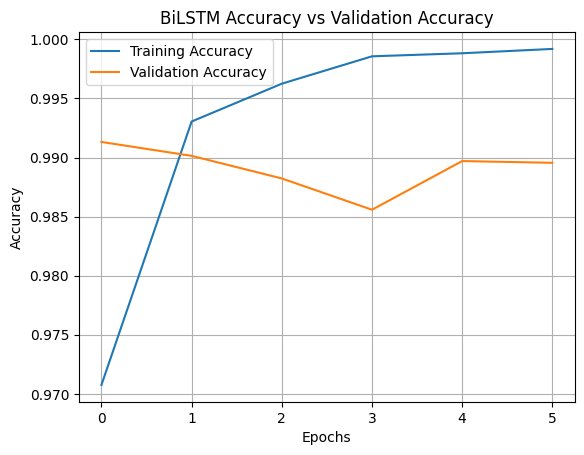

In [5]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('BiLSTM Accuracy vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [6]:
import pickle

# Lưu tokenizer
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

In [10]:
from tensorflow.keras.models import load_model

model = load_model('best_bilstm_model.keras')
with open('tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f)

def predict(sample_title, sample_content):
    seq_title = tokenizer.texts_to_sequences([sample_title])
    seq_content = tokenizer.texts_to_sequences([sample_content])

    pad_title = pad_sequences(seq_title, maxlen=max_len_title)
    pad_content = pad_sequences(seq_content, maxlen=max_len_content)

    prediction = model.predict([pad_title, pad_content])
    label = int(prediction[0][0] > 0.5)

    print(f"Xác suất tin thật: {prediction[0][0]:.4f}")
    print("Dự đoán:", "FAKE" if label == 0 else "REAL")


In [ ]:
sample_title = "Trung ương thống nhất sáp nhập còn 34 tỉnh, thành, giảm 60-70 xã"
sample_content = """
Ban Chấp hành Trung ương thống nhất đơn vị hành chính cấp tỉnh sau sáp nhập là 34 tỉnh, thành phố (28 tỉnh và 6 thành phố trực thuộc Trung ương), giảm khoảng 60-70% số lượng đơn vị hành chính cấp xã.
Chiều 12/4, tại Trụ sở Trung ương Đảng, Hội nghị lần thứ 11 Ban Chấp hành Trung ương Đảng khóa 13 bế mạc. 

Phát biểu bế mạc, Tổng Bí thư Tô Lâm cho biết, sau 3 ngày làm việc khẩn trương, với tinh thần trách nhiệm cao, các ủy viên Trung ương đã thảo luận hết sức dân chủ, lắng nghe, trao đổi thẳng thắn nhiều vấn đề mới, hệ trọng và thống nhất rất cao những nội dung quan trọng, cốt lõi.

Ban chấp hành Trung ương đã biểu quyết thông qua Nghị quyết hội nghị với tỷ lệ tuyệt đối.
Tổng Bí thư cho biết, Hội nghị Trung ương 11 khoá 13 đã hoàn thành toàn bộ nội dung, chương trình đề ra.

"Rất nhiều đồng chí Trung ương đề nghị Bộ Chính trị ghi nhận đây là hội nghị lịch sử, bàn về những quyết sách lịch sử trong giai đoạn Cách mạng mới của nước ta", Tổng Bí thư chia sẻ.
Thay mặt Bộ Chính trị, Ban Bí thư, Tổng Bí thư ghi nhận, đánh giá cao, biểu dương tinh thần làm việc tích cực, trách nhiệm, chủ động, khoa học, sáng tạo, quyết đoán, hiệu quả, đổi mới của Trung ương; công tác chuẩn bị và phục vụ Hội nghị chu đáo, kỹ lưỡng, trọng tâm, trọng điểm, có nhiều cải tiến của các Tiểu ban, của Văn phòng Trung ương Đảng và các cơ quan liên quan. 

Thống nhất cả nước còn 28 tỉnh và 6 thành phố trực thuộc Trung ương

Ban Chấp hành Trung ương thống nhất cao nội dung đề xuất nêu tại các tờ trình, báo cáo, đề án thuộc nhóm công việc về tiếp tục sắp xếp tổ chức bộ máy của hệ thống chính trị, sắp xếp đơn vị hành chính và tổ chức chính quyền địa phương 2 cấp.

Trong đó, Tổng Bí thư nêu rõ, "Ban Chấp hành Trung ương nhấn mạnh: Việc tiếp tục sắp xếp tổ chức bộ máy của hệ thống chính trị là quyết sách chiến lược chưa từng có với mục tiêu cao nhất vì sự phát triển nhanh, ổn định, bền vững của đất nước, chăm lo tốt hơn đời sống của nhân dân".

Xây dựng bộ máy chính quyền tinh gọn, chuyển từ quản lý thụ động sang chủ động phục vụ nhân dân, kiến tạo phát triển, đủ năng lực tổ chức triển khai có hiệu quả các chủ trương của Đảng vào thực tiễn cuộc sống trong kỷ nguyên phát triển và thịnh vượng.

Việc sắp xếp đơn vị hành chính địa phương lần này được xây dựng trên tinh thần khoa học, đột phá, sáng tạo, bám sát thực tiễn với tầm nhìn xa, trông rộng, ít nhất là 100 năm, bảo đảm hình thành và mở rộng không gian phát triển kinh tế, xã hội, văn hóa mới phù hợp cho phát triển đất nước.

Chính quyền địa phương sau sắp xếp phải bảo đảm tinh gọn, hiệu quả, gần dân, đáp ứng các yêu cầu quản trị xã hội hiện đại, thực hiện được các mục tiêu tăng trưởng nhanh, bền vững. Ngoài ra, tạo thế và lực mới cho nhiệm vụ đảm bảo quốc phòng, an ninh, đối ngoại; tạo đà và động lực cho phát triển kinh tế, trong đó chú trọng thúc đẩy kinh tế tư nhân; đẩy nhanh phát triển khoa học công nghệ và đổi mới sáng tạo; chăm lo ngày một tốt hơn đời sống vật chất, tinh thần của nhân dân.

Việc sắp xếp lại mô hình, tổ chức MTTQ Việt Nam và các tổ chức chính trị - xã hội, các hội quần chúng được Đảng, Nhà nước giao nhiệm vụ phải thực sự tinh gọn, bảo đảm không trùng lắp, chồng chéo về chức năng, nhiệm vụ.

Tổng Bí thư khẳng định, việc sắp xếp sẽ không hành chính hoá hoạt động, hướng mạnh về địa bàn dân cư, gần dân, sát dân, phục vụ nhân dân theo tinh thần “chú trọng và thực hành dân làm gốc”, phải thực sự là “cánh tay nối dài” của Đảng đến từng hộ gia đình, từng người dân; phải chăm lo quyền, lợi ích hợp pháp, chính đáng của các đoàn viên, hội viên và của nhân dân.

Thực hiện nghiêm nguyên tắc Đảng thống nhất lãnh đạo xây dựng tổ chức bộ máy, công tác cán bộ, quản lý đội ngũ cán bộ và biên chế của hệ thống chính trị. Tiếp tục đổi mới, hoàn thiện và thực hiện đồng bộ, chặt chẽ các quy định về công tác cán bộ ở các cấp, các ngành, địa phương theo nguyên tắc công khai, minh bạch, tăng cường kiểm soát quyền lực, gắn quyền lực với trách nhiệm cá nhân.

Nhận diện, có biện pháp phòng ngừa, kiên quyết đấu tranh xử lý nghiêm các hành vi tham nhũng, lãng phí, tiêu cực, gây mất đoàn kết, chạy chức chạy quyền, cục bộ bè phái trong quá trình sắp xếp tổ chức bộ máy, xử lý tài sản công…

Ban Chấp hành Trung ương thống nhất cao các chủ trương: về tổ chức chính quyền địa phương 2 cấp: cấp Tỉnh (Tỉnh, Thành phố trực thuộc Trung ương), cấp Xã (Xã, Phường, Đặc khu trực thuộc tỉnh, thành phố).

Số lượng đơn vị hành chính cấp tỉnh sau sáp nhập là 34 tỉnh, thành phố (28 tỉnh và 6 thành phố trực thuộc Trung ương) với tên gọi và trung tâm hành chính - chính trị xác định theo các nguyên tắc nêu tại các tờ trình và đề án.

Kết thúc hoạt động của đơn vị hành chính cấp huyện sau khi Quốc Hội quyết nghị sửa đổi, bổ sung một số điều của Hiến pháp năm 2013 và Luật Tổ chức chính quyền địa phương năm 2025 (sửa đổi).

Sáp nhập đơn vị hành chính cấp xã bảo đảm cả nước giảm khoảng 60-70 số lượng đơn vị hành chính cấp xã hiện nay.

Ban Chấp hành Trung ương đồng ý chủ trương lập tổ chức đảng ở địa phương tương ứng với hệ thống hành chính cấp tỉnh, cấp xã; kết thúc hoạt động của các đảng bộ cấp huyện; việc lập tổ chức đảng ở địa phương thực hiện theo đúng Điều lệ Đảng, quy định của Trung ương.

Phân nhiều quyền hơn cho cấp xã

Với mô hình tổ chức hành chính mới, cấp tỉnh vừa là cấp thực hiện chủ trương, chính sách từ Trung ương, vừa là cấp ban hành chính sách trên địa bàn tỉnh, thành phố và trực tiếp chỉ đạo, quản lý các hoạt động của cấp xã trên địa bàn.

Cấp xã chủ yếu là thực hiện chính sách từ cấp Trung ương và cấp tỉnh ban hành. Cấp xã cũng được tăng cường phân cấp phân quyền và có thẩm quyền ban hành văn bản qui phạm pháp luật để quyết định việc tổ chức thi hành pháp luật trên địa bàn và quyết định các vấn đề thuộc thẩm quyền của cấp mình.
Ban Chấp hành Trung ương thống nhất chủ trương sắp xếp, tinh gọn, hợp nhất cơ quan MTTQ Việt Nam, các tổ chức chính trị - xã hội, các hội quần chúng do Đảng, Nhà nước giao nhiệm vụ ở cấp Trung ương, cấp tỉnh và cấp xã nêu tại tờ trình và đề án của Đảng ủy MTTQ Việt Nam, các đoàn thể Trung ương; chủ trương kết thúc hoạt động của công đoàn viên chức, công đoàn lực lượng vũ trang, giảm mức đóng góp công đoàn phí của cán bộ, công chức, viên chức và người lao động.

Ban Chấp hành Trung ương đồng ý chủ trương tiếp tục sắp xếp, tinh gọn bộ máy TAND, Viện KSND; kết thúc hoạt động của TAND, Viện VKSND cấp cao và cấp huyện; xác lập hệ thống tổ chức TAND, Viện KSND có 3 cấp. Đó là: TAND và Viện KSND tối cao; TAND và VKSND cấp tỉnh, thành phố trực thuộc Trung ương và khu vực (hệ thống tòa án và viện kiểm sát quân sự giữ nguyên mô hình hiện nay).
"""
predict(sample_title, sample_content)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step
Xác suất tin thật: 0.9750
Dự đoán: REAL


In [ ]:
sample_title = "Sốc: Sơn Tùng bị fan cuồng lao thẳng vào người khi đang trên sân khấu, để lộ vết xước gây xót xa"
sample_content = """
Sơn Tùng M-TP khiến nhiều khán giả thót tim với sự cố trong đêm nhạc mới đây.
Đại nhạc hội có Sơn Tùng M-TP ế vé, dân mạng bóc loạt vấn đề - người ảnh hưởng nhất là nghệ sĩ! 
Phản ứng của Sơn Tùng M-TP khi nghe ca khúc gây tranh cãi của MONO 
Lý do Hoà Minzy khó lật đổ kỷ lục của Sơn Tùng M-TP 
Tối 12/4, sự kiện âm nhạc diễn ra tại Hạ Long, Quảng Ninh quy tụ nhiều nghệ sĩ đình đám showbiz như Sơn Tùng M-TP, Isaac, Hoàng Dũng, Orange đã chính thức diễn ra. Đặc biệt một trong những màn trình diễn được chờ đợi nhất đó chính sự xuất hiện của Sơn Tùng M-TP. Xuyên suốt hơn 1 tiếng đồng hồ, nam ca sĩ đã mang đến loạt 9 bản hit trong sự nghiệp và khiến hàng chục nghìn khán giả có mặt không ngừng phấn khích. Tuy nhiên, một sự cố đã xảy ra khiến toàn bộ khán giả "thót tim". 

Clip sự cố của Sơn Tùng M-TP tại đêm nhạc (nguồn: lamnhim27)

Cụ thể, khi gần khép lại chương trình, một khán giả đã bất ngờ lao thẳng lên sân khấu và ôm chầm Sơn Tùng M-TP khiến nam ca sĩ không giấu được sự hoảng hốt. Fan cuồng này còn quá khích đến mức liên tục nhảy lên người, ôm chặt làm toàn bộ khán giả "đứng tim" vì tình huống nguy hiểm xảy ra quá nhanh. Dù ngay sau đó, vệ sĩ đã nhanh chóng có mặt nhưng Sơn Tùng M-TP đã bị cào xước dài ở tay. 
Đây không phải lần đầu tiên Sơn Tùng M-TP gặp tình huống bị khán giả lao lên sân khấu nhưng là lần đầu tiên những người có mặt cảm nhận được rõ sự nguy hiểm của tình huống này. Cộng đồng mạng cho rằng nếu như đây không phải là fan cuồng quá khích mà là một người có ý đồ xấu thì không biết hậu quả sẽ nặng nề như thế nào. Mặt khác, Sơn Tùng M-TP luôn là nam ca sĩ được bảo vệ một cách nghiêm ngặt từ lực lượng bảo an nhưng việc liên tục gặp phải những tình huống liên tục khiến người hâm mộ chân chính không khỏi lo lắng. 
"""
predict(sample_title, sample_content)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Xác suất tin thật: 0.0065
Dự đoán: FAKE
